# Stockholm Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
# Read in Stockholm data source csv
# It looks like pm2.5 was not originally included in this data set. 
stockholm_df = pd.read_csv('Resources/stockholm_data.csv', delimiter=", ")
stockholm_df.head()



/Users/kathrynrigsby/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,date,pm25,pm10,no2
0,2020/7/2,13.0,14,9.0
1,2020/7/3,17.0,13,9.0
2,2020/7/4,13.0,8,7.0
3,2020/7/5,11.0,7,6.0
4,2020/7/6,14.0,10,5.0


In [3]:
# Dropping columns not using
dropped_stockholm_df = stockholm_df.drop(["pm10","no2"],axis=1)
dropped_stockholm_df.head()

,date,pm25
0,2020/7/2,13.0
1,2020/7/3,17.0
2,2020/7/4,13.0
3,2020/7/5,11.0
4,2020/7/6,14.0


In [4]:
# Changing datatype from object to datetime
dropped_stockholm_df["date"] = pd.to_datetime(dropped_stockholm_df["date"])

In [5]:
# Dropping any data before 2017
droppedB4_17 = dropped_stockholm_df.loc[(dropped_stockholm_df["date"]>"2017-01-01")].dropna(how="any")
droppedB4_17.to_csv("droppedB4_17.csv")

### 2017 Data

In [6]:
# Dropping all data not January - July 2017
stockholm_data_17 = droppedB4_17.loc[(droppedB4_17["date"]<"2017-07-25")].dropna(how='any')
stockholm_data_17

,date,pm25


* no usable data from 2017

### 2018 Data

In [7]:
# Dropping all except data from January - July of 2018
stockholm_data_18 = droppedB4_17.loc[(droppedB4_17["date"]>"2017-12-31")&(droppedB4_17["date"]<"2018-07-25")].dropna(how='any')

In [8]:
# Create AQI column
stockholm_data_18["AQI"]=""

In [9]:
# Calculate AQI
AQI2018 = []
for value in stockholm_data_18["pm25"]:
    if value >= 0 and value <= 12:
        AQI2018.append((((50-0)/(12-0))*(value-0))+ 0)
    elif value >=12.1 and value <= 35.4:
        AQI2018.append((((100-51)/(35.4-12.1))*(value-12.1))+51)
    elif value >= 35.5 and value <= 55.4:
        AQI2018.append((((150-101)/(55.4-35.5))*(value-35.5))+101)
    elif value >= 55.5 and value<= 150.4:
        AQI2018.append((((200-151)/(150.4-55.4))*(value-55.5))+151)
    elif value >= 150.5 and value <=250.4:
        AQI2018.append((((300-201)/(250.4-150.5))*(value-150.5))+201)
    elif value >= 250.5 and value <= 350.4:
        AQI2018.append((((400-301)/(350.4-250.5))*(value-250.5))+ 301)
    elif value >= 350.5 and value <= 500.4:
        AQI2018.append((((500-401)/(500.4-350.5))*(value-350.5))+ 401)
    else:
        AQI2018.append("invalid")
AQI2018 = [round(i,1) for i in AQI2018]

In [10]:
# Add newly AQI calculated values to AQI column
stockholm_data_18["AQI"] = AQI2018
stockholm_data_18.head()

,date,pm25,AQI
652,2018-07-02,9.0,37.5
653,2018-07-03,16.0,59.2
654,2018-07-04,24.0,76.0
655,2018-07-05,21.0,69.7
656,2018-07-06,19.0,65.5


In [11]:
# Create bins and labels
bins = [0,50,100,150,200,300,500]
quality = ["Good","Moderate","Unhealthy for Sensitive Groups","Unhealthy","Very Unhealthy","Hazardous"]

In [12]:
# Use bins and labels to create quality of AQI
stockholm_data_18["Levels of Concern"] = pd.cut(stockholm_data_18["AQI"],bins,labels=quality,include_lowest=True)
stockholm_data_18

,date,pm25,AQI,Levels of Concern
652,2018-07-02,9.0,37.5,Good
653,2018-07-03,16.0,59.2,Moderate
654,2018-07-04,24.0,76.0,Moderate
655,2018-07-05,21.0,69.7,Moderate
656,2018-07-06,19.0,65.5,Moderate
...,...,...,...,...
911,2018-03-28,43.0,119.5,Unhealthy for Sensitive Groups
912,2018-03-29,62.0,154.4,Unhealthy
913,2018-03-30,48.0,131.8,Unhealthy for Sensitive Groups
914,2018-03-31,32.0,92.8,Moderate


In [13]:
# Export Stockholm data to csv
stockholm_data_18.sort_values(by=["date"]).to_csv("output_data/stockholm_data_18.csv")

In [14]:
# Groupby date and calculate Mean,Max,Min
calculate_18 = stockholm_data_18.groupby(stockholm_data_18["date"].dt.strftime('%m'))
mean_df =calculate_18[["pm25","AQI"]].mean().reset_index(drop=False,inplace=False)
max_df = calculate_18[["pm25","AQI"]].max()
min_df = calculate_18[["pm25","AQI"]].min()

In [15]:
# Merge mean_df,max_df
result = pd.merge(mean_df,max_df, how='outer', on=['date'],suffixes=("_avg","_max"))

In [16]:
# Merge result,min_df
result2 = pd.merge(result,min_df, how='outer',on=['date'])

In [17]:
# Rename columns
stockholm_2018_month_df = result2.rename(columns={
                                    
                                    "date":"Month",
                                    "pm25_avg":"Avg pm2.5",
                                    "AQI_avg":"Avg AQI",
                                    "pm25_max":"Max pm2.5",
                                    "AQI_max":"Max AQI",
                                    "pm25":"Min pm2.5",
                                    "AQI":"Min AQI"
 })
stockholm_2018_month_df

,Month,Avg pm2.5,Avg AQI,Max pm2.5,Max AQI,Min pm2.5,Min AQI
0,01,27.466667,84.100000,58.0,152.3,9.0,37.5
1,02,29.821429,89.375000,50.0,136.7,9.0,37.5
2,03,41.354839,114.922581,63.0,154.9,20.0,67.6
3,04,41.266667,112.823333,74.0,160.5,17.0,61.3
4,05,38.516129,108.261290,66.0,156.4,18.0,63.4
5,06,22.222222,72.044444,40.0,112.1,9.0,37.5
6,07,30.166667,89.858333,53.0,144.1,9.0,37.5


In [18]:
# Dropping columns no longer using
stockholm_2018_df = stockholm_2018_month_df.drop(['Avg pm2.5', 'Max pm2.5','Max AQI','Min pm2.5','Min AQI'], axis=1)

### 2019 Data

In [19]:
# Dropping all except January - July of 2019
stockholm_data_19 = droppedB4_17.loc[(droppedB4_17["date"]>"2018-12-31")&(droppedB4_17["date"]<"2019-07-25")].dropna(how='any')

In [20]:
# Create new AQI column
stockholm_data_19["AQI"]=""

In [21]:
# Calculate AQI
AQI2019 = []
for value in stockholm_data_19["pm25"]:
    if value >= 0 and value <= 12:
        AQI2019.append((((50-0)/(12-0))*(value-0))+ 0)
    elif value >=12.1 and value <= 35.4:
        AQI2019.append((((100-51)/(35.4-12.1))*(value-12.1))+51)
    elif value >= 35.5 and value <= 55.4:
        AQI2019.append((((150-101)/(55.4-35.5))*(value-35.5))+101)
    elif value >= 55.5 and value<= 150.4:
        AQI2019.append((((200-151)/(150.4-55.4))*(value-55.5))+151)
    elif value >= 150.5 and value <=250.4:
        AQI2019.append((((300-201)/(250.4-150.5))*(value-150.5))+201)
    elif value >= 250.5 and value <= 350.4:
        AQI2019.append((((400-301)/(350.4-250.5))*(value-250.5))+ 301)
    elif value >= 350.5 and value <= 500.4:
        AQI2019.append((((500-401)/(500.4-350.5))*(value-350.5))+ 401)
    else:
        AQI2019.append("invalid")
AQI2019 = [round(i,1) for i in AQI2019]

In [22]:
# Add newly calculated AQI values to AQI column
stockholm_data_19["AQI"] = AQI2019
stockholm_data_19.head()

,date,pm25,AQI
297,2019-07-02,23.0,73.9
298,2019-07-03,15.0,57.1
299,2019-07-04,12.0,50.0
300,2019-07-05,12.0,50.0
301,2019-07-06,9.0,37.5


In [23]:
# Create bins and labels
bins = [0,50,100,150,200,300,500]
quality = ["Good","Moderate","Unhealthy for Sensitive Groups","Unhealthy","Very Unhealthy","Hazardous"]

In [24]:
# Use bins and labels to create quality of AQI
stockholm_data_19["Levels of Concern"] = pd.cut(stockholm_data_19["AQI"],bins,labels=quality,include_lowest=True)
stockholm_data_19

,date,pm25,AQI,Levels of Concern
297,2019-07-02,23.0,73.9,Moderate
298,2019-07-03,15.0,57.1,Moderate
299,2019-07-04,12.0,50.0,Good
300,2019-07-05,12.0,50.0,Good
301,2019-07-06,9.0,37.5,Good
...,...,...,...,...
565,2019-03-28,33.0,95.0,Moderate
566,2019-03-29,42.0,117.0,Unhealthy for Sensitive Groups
567,2019-03-30,35.0,99.2,Moderate
568,2019-03-31,38.0,107.2,Unhealthy for Sensitive Groups


In [25]:
# Export sorted Stockholm data to csv
stockholm_data_19.sort_values(by=["date"]).to_csv("output_data/stockholm_data_19.csv")

In [26]:
# Groupby date and calculate Mean,Max,Min
calculate_19 = stockholm_data_19.groupby(stockholm_data_19["date"].dt.strftime('%m'))
mean_df =calculate_19[["pm25","AQI"]].mean().reset_index(drop=False,inplace=False)
max_df = calculate_19[["pm25","AQI"]].max()
min_df = calculate_19[["pm25","AQI"]].min()

In [27]:
# Merge mean_df,max_df
result = pd.merge(mean_df,max_df, how='outer', on=['date'],suffixes=("_avg","_max"))

In [28]:
# Merge result,min_df
result2 = pd.merge(result,min_df, how='outer',on=['date'])
result2

,date,pm25_avg,AQI_avg,pm25_max,AQI_max,pm25,AQI
0,01,25.933333,79.716667,65.0,155.9,9.0,37.5
1,02,37.607143,106.160714,64.0,155.4,23.0,73.9
2,03,26.741935,82.041935,46.0,126.9,10.0,41.7
3,04,48.633333,122.110000,100.0,174.0,21.0,69.7
4,05,30.161290,90.400000,59.0,152.8,13.0,52.9
5,06,27.633333,84.306667,61.0,153.8,11.0,45.8
6,07,19.416667,65.750000,37.0,104.7,9.0,37.5


In [29]:
# Rename columns
stockholm_2019_month_df = result2.rename(columns={
                                    
                                    "date":"Month",
                                    "pm25_avg":"Avg pm2.5",
                                    "AQI_avg":"Avg AQI",
                                    "pm25_max":"Max pm2.5",
                                    "AQI_max":"Max AQI",
                                    "pm25":"Min pm2.5",
                                    "AQI":"Min AQI"
 })
stockholm_2019_month_df

,Month,Avg pm2.5,Avg AQI,Max pm2.5,Max AQI,Min pm2.5,Min AQI
0,01,25.933333,79.716667,65.0,155.9,9.0,37.5
1,02,37.607143,106.160714,64.0,155.4,23.0,73.9
2,03,26.741935,82.041935,46.0,126.9,10.0,41.7
3,04,48.633333,122.110000,100.0,174.0,21.0,69.7
4,05,30.161290,90.400000,59.0,152.8,13.0,52.9
5,06,27.633333,84.306667,61.0,153.8,11.0,45.8
6,07,19.416667,65.750000,37.0,104.7,9.0,37.5


In [30]:
# Dropping columns no longer using
stockholm_2019_df = stockholm_2019_month_df.drop(['Avg pm2.5', 'Max pm2.5','Max AQI','Min pm2.5','Min AQI'], axis=1)

### 2020 Data

In [31]:
# Dropping all except January - July of 2020
stockholm_data_20 = droppedB4_17.loc[(droppedB4_17["date"]>"2019-12-31")&(droppedB4_17["date"]<"2020-07-25")].dropna(how='any')

In [32]:
# Create new AQI column
stockholm_data_20["AQI"]=""

In [33]:
# Calculate AQI
AQI2020 = []
for value in stockholm_data_20["pm25"]:
    if value >= 0 and value <= 12:
        AQI2020.append((((50-0)/(12-0))*(value-0))+ 0)
    elif value >=12.1 and value <= 35.4:
        AQI2020.append((((100-51)/(35.4-12.1))*(value-12.1))+51)
    elif value >= 35.5 and value <= 55.4:
        AQI2020.append((((150-101)/(55.4-35.5))*(value-35.5))+101)
    elif value >= 55.5 and value<= 150.4:
        AQI2020.append((((200-151)/(150.4-55.4))*(value-55.5))+151)
    elif value >= 150.5 and value <=250.4:
        AQI2020.append((((300-201)/(250.4-150.5))*(value-150.5))+201)
    elif value >= 250.5 and value <= 350.4:
        AQI2020.append((((400-301)/(350.4-250.5))*(value-250.5))+ 301)
    elif value >= 350.5 and value <= 500.4:
        AQI2020.append((((500-401)/(500.4-350.5))*(value-350.5))+ 401)
    else:
        AQI2020.append("invalid")
AQI2020 = [round(i,1) for i in AQI2020]

In [34]:
# Add newly calculated AQI to column in dataframe
stockholm_data_20["AQI"] = AQI2020
stockholm_data_20.head()

,date,pm25,AQI
0,2020-07-02,13.0,52.9
1,2020-07-03,17.0,61.3
2,2020-07-04,13.0,52.9
3,2020-07-05,11.0,45.8
4,2020-07-06,14.0,55.0


In [35]:
# Create bins and labels
bins = [0,50,100,150,200,300,500]
quality = ["Good","Moderate","Unhealthy for Sensitive Groups","Unhealthy","Very Unhealthy","Hazardous"]

In [36]:
# Use bins and labels to create quality of AQI
stockholm_data_20["Levels of Concern"] = pd.cut(stockholm_data_20["AQI"],bins,labels=quality,include_lowest=True)
stockholm_data_20

,date,pm25,AQI,Levels of Concern
0,2020-07-02,13.0,52.9,Moderate
1,2020-07-03,17.0,61.3,Moderate
2,2020-07-04,13.0,52.9,Moderate
3,2020-07-05,11.0,45.8,Good
4,2020-07-06,14.0,55.0,Moderate
...,...,...,...,...
204,2020-01-28,39.0,109.6,Unhealthy for Sensitive Groups
205,2020-01-29,39.0,109.6,Unhealthy for Sensitive Groups
206,2020-01-30,20.0,67.6,Moderate
207,2020-01-31,24.0,76.0,Moderate


In [37]:
# Export Stockholm data to csv
stockholm_data_20.sort_values(by=["date"]).to_csv("output_data/stockholm_data_20.csv")

In [38]:
# Groupby date and calculate Mean,Max,Min
calculate_20 = stockholm_data_20.groupby(stockholm_data_20["date"].dt.strftime('%m'))
mean_df =calculate_20[["pm25","AQI"]].mean().reset_index(drop=False,inplace=False)
max_df = calculate_20[["pm25","AQI"]].max()
min_df = calculate_20[["pm25","AQI"]].min()

In [39]:
#Merge mean_df, max_df
result = pd.merge(mean_df,max_df, how='outer', on=['date'],suffixes=("_avg","_max"))

In [40]:
# Merge result,min_df
result2 = pd.merge(result,min_df, how='outer',on=['date'])
result2

,date,pm25_avg,AQI_avg,pm25_max,AQI_max,pm25,AQI
0,01,23.400000,75.056667,47.0,129.3,10.0,41.7
1,02,19.137931,65.079310,40.0,112.1,7.0,29.2
2,03,27.258065,83.838710,61.0,153.8,11.0,45.8
3,04,18.166667,62.866667,57.0,151.8,8.0,33.3
4,05,16.774194,59.332258,29.0,86.5,7.0,29.2
5,06,23.866667,75.536667,40.0,112.1,8.0,33.3
6,07,14.083333,52.050000,27.0,82.3,6.0,25.0


In [41]:
# Rename columns
stockholm_2020_month_df = result2.rename(columns={
                                    
                                    "date":"Month",
                                    "pm25_avg":"Avg pm2.5",
                                    "AQI_avg":"Avg AQI",
                                    "pm25_max":"Max pm2.5",
                                    "AQI_max":"Max AQI",
                                    "pm25":"Min pm2.5",
                                    "AQI":"Min AQI"
 })
stockholm_2020_month_df

,Month,Avg pm2.5,Avg AQI,Max pm2.5,Max AQI,Min pm2.5,Min AQI
0,01,23.400000,75.056667,47.0,129.3,10.0,41.7
1,02,19.137931,65.079310,40.0,112.1,7.0,29.2
2,03,27.258065,83.838710,61.0,153.8,11.0,45.8
3,04,18.166667,62.866667,57.0,151.8,8.0,33.3
4,05,16.774194,59.332258,29.0,86.5,7.0,29.2
5,06,23.866667,75.536667,40.0,112.1,8.0,33.3
6,07,14.083333,52.050000,27.0,82.3,6.0,25.0


In [42]:
# Dropping columns no longer using
stockholm_2020_df = stockholm_2020_month_df.drop(['Avg pm2.5', 'Max pm2.5','Max AQI','Min pm2.5','Min AQI'], axis=1)

### Merging the Data

In [43]:
# Merge stockholm_2018_df,stockholm_2019_df
monthly1 = pd.merge(stockholm_2018_df,stockholm_2019_df,how='outer',on=["Month"],suffixes=("_18","_19"))

In [44]:
# Merge monthly1,stockholm_2020_df
monthly2 = pd.merge(monthly1,stockholm_2020_df,how='outer',on=["Month"])
monthly2

,Month,Avg AQI_18,Avg AQI_19,Avg AQI
0,01,84.100000,79.716667,75.056667
1,02,89.375000,106.160714,65.079310
2,03,114.922581,82.041935,83.838710
3,04,112.823333,122.110000,62.866667
4,05,108.261290,90.400000,59.332258
5,06,72.044444,84.306667,75.536667
6,07,89.858333,65.750000,52.050000


In [45]:
# Rename columns
stockholm_summary_data = monthly2.rename(columns={
                                                "Avg AQI":"Avg AQI_20"
                                                
                                                })
stockholm_summary_data

,Month,Avg AQI_18,Avg AQI_19,Avg AQI_20
0,01,84.100000,79.716667,75.056667
1,02,89.375000,106.160714,65.079310
2,03,114.922581,82.041935,83.838710
3,04,112.823333,122.110000,62.866667
4,05,108.261290,90.400000,59.332258
5,06,72.044444,84.306667,75.536667
6,07,89.858333,65.750000,52.050000


In [46]:
# Export final Stockholm data to csv
stockholm_summary_data.to_csv("output_data/stockholm_summary_data.csv",index=False)

### Plotting the Data

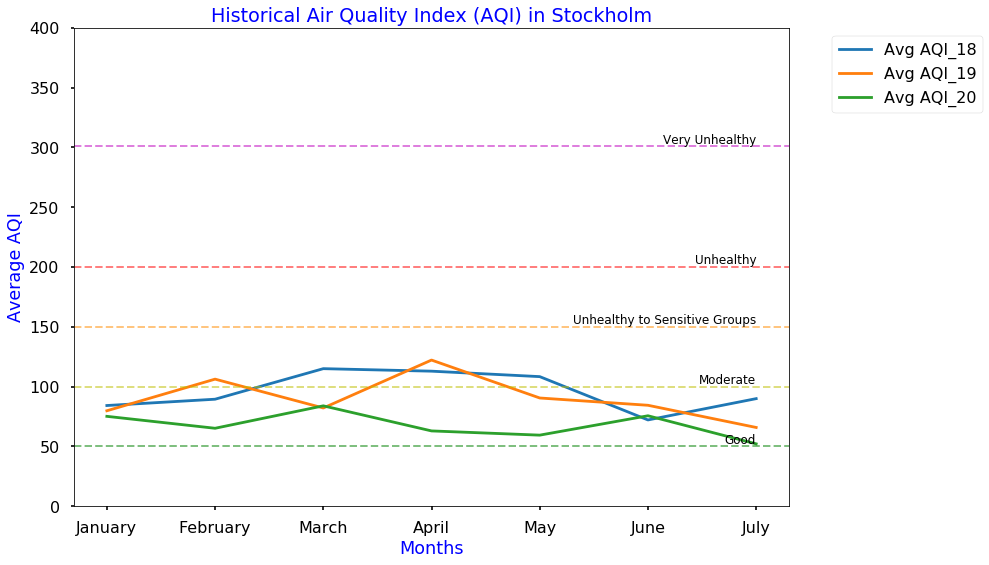

In [48]:
# Plotting the Average AQI for January - July from 2017,2018, 2019
plt.style.use('seaborn-poster')
stockholm_summary_data.plot(y=["Avg AQI_18","Avg AQI_19","Avg AQI_20"])
plt.title("Average AQI", color="blue")
plt.xlabel("Months",color="blue")
plt.ylabel("AQI",color="blue")
plt.xticks(np.arange(7),("January","February","March","April","May","June","July"))


plt.axhline(y=301,color='m', alpha=.5, linestyle='--', lw=2)
plt.text(6,301,'Very Unhealthy', ha='right', va='bottom', fontsize=12)
plt.axhline(y=200,color='r', alpha=.5, linestyle='--', lw=2)
plt.text(6,200,'Unhealthy', ha='right', va='bottom', fontsize=12)
plt.axhline(y=150,color='darkorange', alpha=.5, linestyle='--', lw=2)
plt.text(6,150,'Unhealthy to Sensitive Groups', ha='right', va='bottom', fontsize=12)
plt.axhline(y=100,color='y', alpha=.5, linestyle='--', lw=2)
plt.text(6,100,'Moderate', ha='right', va='bottom', fontsize=12)
plt.axhline(y=50,color='g', alpha=.5, linestyle='--', lw=2)
plt.text(6,50,'Good', ha='right', va='bottom', fontsize=12)
plt.ylim(0,400)
plt.title("Historical Air Quality Index (AQI) in Stockholm")
plt.legend(loc=9, bbox_to_anchor=(.5,.9),ncol=4)
#plt.legend(bbox_to_anchor=(1.05,1.0),loc='upper left')
plt.ylabel("Average AQI")

plt.savefig("output_data/stockholm_plot.png")
plt.show()

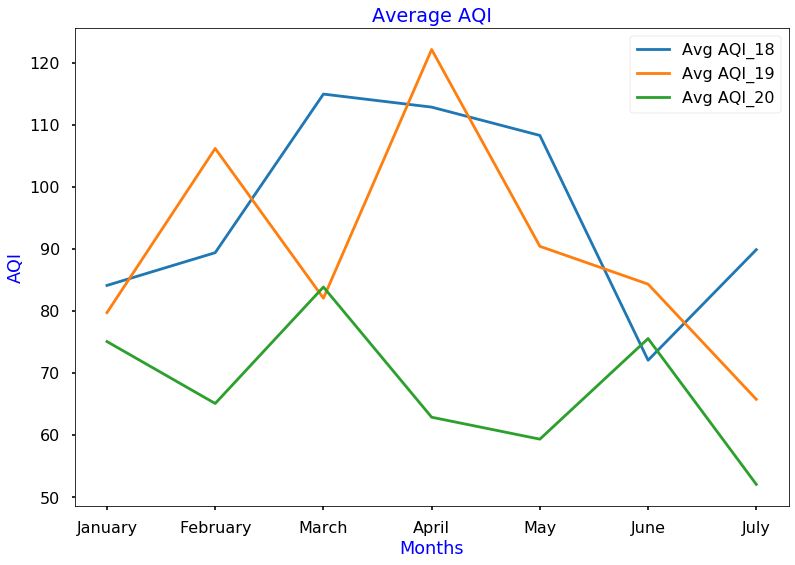

In [49]:
plt.style.use('seaborn-poster')
stockholm_summary_data.plot(y=["Avg AQI_18","Avg AQI_19","Avg AQI_20"])
plt.title("Average AQI", color="blue")
plt.xlabel("Months",color="blue")
plt.ylabel("AQI",color="blue")
plt.xticks(np.arange(7),("January","February","March","April","May","June","July"))
plt.savefig("output_data/stockholm_plot2.png")
plt.show()

### Shut down Policy
* Sweden instituted absolutely no policy on area or country wide shut downs
* They opted for hopes in herd immunity, which, according to Johns Hopkins, is when most of a population is immune
to a particular disease and provides protection for those that are not immune. Two ways to achieve herd immunity:
vaccines or protection from prior infection

(https://www.jhsph.edu/covid-19/articles/achieving-herd-immunity-with-covid19.html)

### Cases

#### Country
* Deaths: 5,730
* Confirmed cases: 79,782

#### Stockholm

* Deaths:2,384
* Confirmed cases: 23,101

* helpful article on Sweden: https://abcnews.go.com/International/sweden-stayed-open-coronavirus-pandemic-model-future/story?id=70666450